In [1]:
import copy
import sys

import einops
import numpy
import numpy as np
import torch

sys.exc_info()
from utils.config import process_config
from datasets.sleepset import *
from graphs.models.attention_models.windowFeature_base import *
from graphs.models.attention_models.windowFeature_base import SleepEnc_Merged_EEG_EOG
from sklearn.metrics import f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from utils.deterministic_pytorch import deterministic
# import umap
from scipy.stats import entropy
import os
from torchdistill.core.forward_hook import ForwardHookManager
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import pandas as pd
%config InlineBackend.figure_format = 'retina'

print("Done Loading Libraries")


Done Loading Libraries


In [2]:
def sleep_load_encoder(enc_args):
    encs = []
    for num_enc in range(len(enc_args)):
        enc_class = globals()[enc_args[num_enc]["model"]]
        args = enc_args[num_enc]["args"]
        print(enc_class)
        if "encoders" in enc_args[num_enc]:
            enc_enc = sleep_load_encoder(enc_args[num_enc]["encoders"])
            enc = enc_class(encs = enc_enc, args = args)
        else:
            enc = enc_class(args = args)
        enc = nn.DataParallel(enc, device_ids=[torch.device(0)])

        if enc_args[num_enc]["pretrainedEncoder"]["use"]:
            print("Loading encoder from {}".format(enc_args[num_enc]["pretrainedEncoder"]["dir"]))
            checkpoint = torch.load(enc_args[num_enc]["pretrainedEncoder"]["dir"])
            if "encoder_state_dict" in checkpoint:
                enc.load_state_dict(checkpoint["encoder_state_dict"])
            elif "model_state_dict" in checkpoint:
                enc.load_state_dict(checkpoint["model_state_dict"])

        encs.append(enc)
    return encs

def load_models(config, device, checkpoint, only_model=False):

    model_class = globals()[config.model.model_class]
    # config.pretrainedEncoder = [False]
    enc = sleep_load_encoder(enc_args=config.model.encoders)
    model = model_class(enc, args = config.model.args)
    # model = model.to('cpu')
    # model = nn.DataParallel(model, device_ids='cpu')
    model = model.to(device)
    model = nn.DataParallel(model, device_ids=[torch.device(i) for i in config.gpu_device])
    # print(device)
    # model = nn.DataParallel(model, device="cpu")

    #
    if only_model:
        return model

    # config.pretrainedEncoder = [True]
    # enc = sleep_load_encoder(encoder_models=config.encoder_models,pretrainedEncoder=config.pretrainedEncoder,save_dir_encoder=config.savetrainedEncoder)
    # best_model = model_class(enc, channel = config.channel)
    # best_model = best_model.to(device)
    # best_model = nn.DataParallel(best_model, device_ids=[torch.device(i) for i in config.gpu_device])

    best_model = copy.deepcopy(model)
    # best_model = best_model.to('cpu')
    # best_model = nn.DataParallel(best_model, device_ids='cpu')
    # model.load_state_dict(checkpoint["model_state_dict"])
    best_model.load_state_dict(checkpoint["best_model_state_dict"])

    return model, best_model

def find_patient_list(data_loader):
    patient_list = [int(data.split("/")[-1][1:5]) for data in data_loader.dataset.dataset[0] if data.split("/")[-1]!="empty"]
    return patient_list

def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)):
        if y_actual[i] == y_hat[i] == 1:
            TP += 1
        if y_hat[i] == 1 and y_actual[i] != y_hat[i]:
            FP += 1
        if y_actual[i] == y_hat[i] == 0:
            TN += 1
        if y_hat[i] == 0 and y_actual[i] != y_hat[i]:
            FN += 1

    return (TP, FP, TN, FN)

def print_perf(model_name, patient_num, preds, tts, multiclass=True):
    if len(preds.shape)==2:
        preds_eeg = preds.argmax(-1)
    else:
        preds_eeg = preds

    test_acc = np.equal(tts, preds_eeg).sum() / len(tts)
    test_f1 = f1_score(preds_eeg, tts) if not multiclass else f1_score(preds_eeg, tts, average="macro")
    test_perclass_f1 = f1_score(preds_eeg, tts) if not multiclass else f1_score(preds_eeg, tts, average=None)
    test_k = cohen_kappa_score(tts, preds_eeg)
    test_auc = roc_auc_score(tts, preds_eeg) if not multiclass else 0
    test_conf = confusion_matrix(tts, preds_eeg)
    tp, fp, tn, fn = perf_measure(tts, preds_eeg)
    test_spec = tn / (tn + fp) if (tn + fp) != 0 else 0
    test_sens = tp / (tp + fn) if (tp + fn) != 0 else 0
    print("{} Patient {} has acc: {}, f1: {}, k:{} and f1_per_class: {}".format(model_name, patient_num,
                                                                             round(test_acc * 100, 1),
                                                                             round(test_f1 * 100, 1),
                                                                             round(test_k, 3),
                                                                             np.round(test_perclass_f1 * 100,
                                                                                      1)))
    return test_k

def get_performance_windows(preds, tts, print_it=True, window=40, type="f1"):

    tts_unfolded = torch.from_numpy(tts).unfold(0, window, window).numpy()
    preds_unfolded = torch.from_numpy(preds).unfold(0, window, window).numpy()

    if type == "accuracy":
        perf_window = np.array([np.equal(tts_unfolded[i], preds_unfolded[i]).sum() / len(tts_unfolded[i]) for i in range(tts_unfolded.shape[0])])
    elif type=="k":
        perf_window = np.array([cohen_kappa_score(tts_unfolded[i], preds_unfolded[i]) for i in range(tts_unfolded.shape[0])])
    elif type=="f1":
        perf_window = np.array([f1_score(tts_unfolded[i], preds_unfolded[i], average="macro") for i in range(tts_unfolded.shape[0])])
    else:
        raise ValueError("This type of performance does not extst, 'accuracy', 'k' and 'f1'")
    perf_window[perf_window != perf_window] = 1
    if print_it:
        for i in perf_window: print("{:.3f}".format(i), end=" ")
        print()
    perf_window = perf_window
    return perf_window

def get_windows(input, window=40):
    input_unfolded = torch.from_numpy(input).unfold(0, window, window).numpy()
    if (input_unfolded != input_unfolded).any(): print("Τhere are nan")
    input_unfolded = input_unfolded.mean(axis=-1)
    # input_unfolded = input_unfolded.repeat(window)
    return input_unfolded

def change_numbers_preds(preds, tts, argmax=True):
    if argmax: pred_plus = copy.deepcopy(preds).argmax(-1)
    else: pred_plus = copy.deepcopy(preds)
    pred_plus[pred_plus == 4] = 5
    pred_plus[pred_plus == 3] = 4
    pred_plus[pred_plus == 2] = 3
    pred_plus[pred_plus == 5] = 2

    target_plus = copy.deepcopy(tts)
    target_plus[target_plus == 4] = 5
    target_plus[target_plus == 3] = 4
    target_plus[target_plus == 2] = 3
    target_plus[target_plus == 5] = 2

    return pred_plus, target_plus

def find_matches(pred_plus, target_plus):

    non_matches = (pred_plus != target_plus).astype(int)
    non_matches_idx = non_matches.nonzero()[0]
    return non_matches_idx

def print_max_perf(predictors, performs, tts, window_floor):
    max_preds = []
    for i in range(len(performs[0])):
        max_mod = np.argmax(np.array([perf[i] for perf in performs]))
        max_preds.append(predictors[max_mod][i*window_floor:(i+1)*window_floor])
    max_preds = np.array(max_preds).flatten()

    multiclass = True
    model_name = "Max"
    test_acc = np.equal(tts, max_preds).sum() / len(tts)
    test_f1 = f1_score(max_preds, tts) if not multiclass else f1_score(max_preds, tts, average="macro")
    test_perclass_f1 = f1_score(max_preds, tts) if not multiclass else f1_score(max_preds, tts, average=None)
    test_k = cohen_kappa_score(tts, max_preds)
    test_auc = roc_auc_score(tts, max_preds) if not multiclass else 0
    test_conf = confusion_matrix(tts, max_preds)
    tp, fp, tn, fn = perf_measure(tts, max_preds)
    test_spec = tn / (tn + fp) if (tn + fp) != 0 else 0
    test_sens = tp / (tp + fn) if (tp + fn) != 0 else 0
    print("{} has acc: {}, f1: {}, k:{} and f1_per_class: {}".format(model_name,
                                                                             round(test_acc * 100, 1),
                                                                             round(test_f1 * 100, 1),
                                                                             round(test_k, 3),
                                                                             np.round(test_perclass_f1 * 100,
                                                                                      1)))
    return test_k, max_preds

def routing_predictor_std(t_eeg, t_eog, views_eeg_time, views_eog_time, predictors):

    #STD Router
    print(views_eeg_time.shape)
    views_eeg_time_hour_std = torch.from_numpy(views_eeg_time).unfold(0,21,21).flatten(start_dim=1).numpy().std(axis=-1)
    views_eog_time_hour_std = torch.from_numpy(views_eog_time).unfold(0,21,21).flatten(start_dim=1).numpy().std(axis=-1)

    # views_eeg_time_hour_std = torch.from_numpy(views_eeg_time_hour_std).numpy()
    # views_eog_time_hour_std = torch.from_numpy(views_eog_time_hour_std).unfold(0,21,21).numpy()

    skip_eeg, skip_eog = np.zeros(len(views_eeg_time_hour_std)), np.zeros(len(views_eog_time_hour_std))

    skip_eeg[views_eeg_time_hour_std.squeeze()> t_eeg] = 1
    skip_eog[views_eog_time_hour_std.squeeze()> t_eog] = 2
    skip_flags = skip_eeg + skip_eog
    skip_flags[skip_flags==3]=0
    counter, router_preds = 0, []
    window_floor = 21
    for i, v in enumerate(np.array(skip_flags).astype(int)):
        router_pred = np.array([np.array(predictors)[v][i*window_floor:(i+1)*window_floor]])
        router_preds.append(router_pred)
    router_preds = np.array(router_preds)
    return router_preds, np.array(skip_flags)

def routing_predictor_zero_crossing(t_eeg, t_eog, views_eeg_time, views_eog_time, predictors):

    views_eeg_time_hour_zero_crossings = einops.rearrange(torch.from_numpy(views_eeg_time).unfold(0,21,21), "b time outer -> b (outer time)")
    views_eeg_time_hour_zero_crossings = einops.rearrange(einops.rearrange(views_eeg_time_hour_zero_crossings, "b t -> t b") - views_eeg_time_hour_zero_crossings.mean(dim=1), "b t -> t b")
    views_eeg_time_hour_zero_crossings = np.array([len(numpy.where(numpy.diff(numpy.sign(views_eeg_time_hour_zero_crossings[i])))[0]) for i in range(0,len(views_eeg_time_hour_zero_crossings))])/21

    views_eog_time_hour_zero_crossings = einops.rearrange(torch.from_numpy(views_eog_time).unfold(0,21,21), "b time outer -> b (outer time)")
    views_eog_time_hour_zero_crossings = einops.rearrange(einops.rearrange(views_eog_time_hour_zero_crossings, "b t -> t b") - views_eog_time_hour_zero_crossings.mean(dim=1), "b t -> t b")
    views_eog_time_hour_zero_crossings = np.array([len(numpy.where(numpy.diff(numpy.sign(views_eog_time_hour_zero_crossings[i])))[0]) for i in range(0,len(views_eog_time_hour_zero_crossings))])/21

    # print(views_eeg_time_hour_zero_crossings.max())
    # print(views_eeg_time_hour_zero_crossings.min())
    #
    # print(views_eog_time_hour_zero_crossings.max())
    # print(views_eog_time_hour_zero_crossings.min())

    skip_eeg, skip_eog = np.zeros(len(views_eeg_time_hour_zero_crossings)), np.zeros(len(views_eog_time_hour_zero_crossings))

    skip_eeg[views_eeg_time_hour_zero_crossings > t_eeg] = 1
    skip_eog[views_eog_time_hour_zero_crossings > t_eog] = 2
    skip_flags = skip_eeg + skip_eog
    skip_flags[skip_flags==3]=0
    counter, router_preds = 0, []
    window_floor = 21
    for i, v in enumerate(np.array(skip_flags).astype(int)):
        router_pred = np.array([np.array(predictors)[v][i*window_floor:(i+1)*window_floor]])
        router_preds.append(router_pred)
    router_preds = np.array(router_preds)
    return router_preds, np.array(skip_flags)
def routing_predictor_final_reps(t_eeg, t_eog, final_reps, predictors):

    a = torch.from_numpy(copy.deepcopy(final_reps)).squeeze()
    b = torch.einsum('bomf,bomf->mb', a, a)

    skip_eeg, skip_eog = np.zeros(len(b[0])), np.zeros(len(b[0]))

    skip_eeg[b[0] > t_eeg] = 1
    skip_eog[b[1] > t_eog] = 2
    skip_flags = skip_eeg + skip_eog
    skip_flags[skip_flags==3]=0
    counter, router_preds = 0, []
    window_floor = 21
    for i, v in enumerate(np.array(skip_flags).astype(int)):
        router_pred = np.array([np.array(predictors)[v][i*window_floor:(i+1)*window_floor]])
        router_preds.append(router_pred)
    router_preds = np.array(router_preds)
    return router_preds, np.array(skip_flags)

def test_metrics(test_preds, tts):
    results = {}
    results["acc"] = np.equal(tts, test_preds).sum() / len(tts)
    results["f1"] = f1_score(test_preds, tts, average="macro")
    results["f1_perclass"] = f1_score(test_preds, tts, average=None)
    results["k"] = cohen_kappa_score(tts, test_preds)
    results["conf"] = confusion_matrix(tts, test_preds)
    tp, fp, tn, fn = perf_measure(tts, test_preds)
    results["spec"] = tn / (tn + fp) if (tn + fp)!=0 else 0
    results["sens"] = tp / (tp + fn) if (tp + fn)!=0 else 0
    return results

print("Done Loading Functions")

Done Loading Functions


In [3]:
multimodal_merged_config_name = "./configs/shhs/multi_modal/eeg_eog/established_models/fourier_transformer_eeg_eog_mat_merged_rpos_adv.json"
multimodal_config_name = "./configs/shhs/multi_modal/eeg_eog/established_models/fourier_transformer_eeg_eog_mat_BIOBLIP_lossw.json"
eeg_config_name = "./configs/shhs/single_channel/fourier_transformer_cls_eeg_mat_adv.json"
eog_config_name = "./configs/shhs/single_channel/fourier_transformer_cls_eog_mat.json"
emg_config_name = "./configs/shhs/single_channel/fourier_transformer_cls_emg_mat.json"
# router_config_name = "./configs/shhs/router/router_fourier_tf_eeg_eog.json"

multimodal_config = process_config(multimodal_config_name, False)
multimodal_merged_config = process_config(multimodal_merged_config_name, False)
eeg_config = process_config(eeg_config_name, False)
eog_config = process_config(eog_config_name, False)
emg_config = process_config(emg_config_name, False)
# router_config = process_config(router_config_name, False)

multimodal_config.data_view_dir = [
            {"list_dir" : "patient_mat_list.txt", "data_type": "stft", "mod": "eeg", "num_ch": 1},
            {"list_dir" :"patient_eog_mat_list.txt", "data_type": "stft", "mod": "eog", "num_ch": 1},
            {"list_dir" : "patient_mat_list.txt", "data_type": "time", "mod": "eeg", "num_ch": 1},
            {"list_dir" : "patient_eog_mat_list.txt", "data_type": "time", "mod": "eog", "num_ch": 1},
        ]

In [4]:
device = "cuda:0"
# device = "cpu"
multimodal_config.test_batch_size=16
#Load the models
checkpoint_multimodal = torch.load(multimodal_config.model.save_dir, map_location="cpu")
# checkpoint_multimodal_merged = torch.load(multimodal_merged_config.model.save_dir, map_location="cpu")
checkpoint_eeg = torch.load(eeg_config.model.save_dir, map_location="cpu")
# checkpoint_eog = torch.load(eog_config.model.save_dir, map_location="cpu")
# checkpoint_emg = torch.load(emg_config.model.save_dir, map_location="cpu")
# checkpoint_router = torch.load(router_config.model.save_dir, map_location="cpu")
dataloader = globals()[multimodal_config.dataloader_class]
data_loader = dataloader(config=multimodal_config)
data_loader.load_metrics_ongoing(checkpoint_multimodal["metrics"])
data_loader.weights = checkpoint_multimodal["logs"]["weights"]

# _, best_model_multimodal = load_models(config=multimodal_config, device=device, checkpoint=checkpoint_multimodal)
# _, best_model_multimodal_merged = load_models(config=multimodal_merged_config, device=device, checkpoint=checkpoint_multimodal_merged)
_, best_model_eeg = load_models(config=eeg_config, device=device, checkpoint=checkpoint_eeg)
# _, best_model_eog = load_models(config=eog_config, device=device, checkpoint=checkpoint_eog)
# _, best_model_emg = load_models(config=emg_config, device=device, checkpoint=checkpoint_emg)
# _, best_model_router = load_models(config=router_config, device=device, checkpoint=checkpoint_router)

# best_model_multimodal = best_model_multimodal.module.to(device)
# best_model_eeg = best_model_eeg.module.to(device)
# best_model_eog = best_model_eog.module.to(device)
# best_model_router = best_model_router.module.to(device)

We are splitting dataset by huy splits
Loading metrics from /esat/biomeddata/SHHS_Dataset/no_backup/metrics_eeg_eog_emg_stft.pkl
{'mean': {'stft_eeg': {'ch_0': array([43.2955597 , 46.28334793, 46.57462871, 46.93142863, 46.71975447,
       46.30992231, 45.73959675, 45.00572276, 44.25611531, 43.54888373,
       42.89470705, 42.29606367, 41.85580365, 41.50708189, 41.17809138,
       40.97493069, 40.89130512, 40.86313329, 40.85836247, 40.80706822,
       40.67444485, 40.47443506, 40.23997197, 39.98101024, 39.70448533,
       39.38744256, 39.02843184, 38.64753164, 38.26702659, 37.89653436,
       37.5438343 , 37.27715182, 37.14046044, 37.14454121, 37.1256875 ,
       36.89050033, 36.41573469, 35.90221754, 35.54059584, 35.12889656,
       34.61938625, 34.21677957, 33.9218631 , 33.67033623, 33.43974529,
       33.21620235, 33.00677379, 32.80971686, 32.61766187, 32.41304556,
       32.20572687, 32.01016978, 31.8115773 , 31.62111692, 31.43249887,
       31.23505222, 31.04081276, 30.84011718, 30

In [10]:
with torch.no_grad():
    best_model_multimodal.eval()
    best_model_eeg.eval()
    best_model_eog.eval()
    # best_model_emg.eval()
    # best_model_router.eval()

    tts, preds, matches, inits, views_eeg, views_eog, views_emg, inter_eeg, inter_eog = [], [], [], [], [], [], [], [], []
    views_eeg_time, views_eog_time, views_emg_time = [], [], []
    router_output, std_choices = [], []
    final_reps = []
    preds_eeg, preds_eog, preds_emg, preds_merged = [], [], [], []
    patient_list_test = [2, 36, 51, 53, 55, 78, 91, 108, 113, 119, 120, 139, 170, 193, 202, 229, 231, 251, 289, 304, 320, 324, 344, 351, 377, 378, 385, 442, 449, 450, 474, 512, 523, 526, 597, 607, 620, 625, 630, 712, 717, 718, 912, 922, 937, 972, 977, 981, 1008, 1030, 1047, 1049, 1058, 1098, 1138, 1150, 1161, 1184, 1198, 1210, 1213, 1229, 1235, 1240, 1243, 1282, 1288, 1300, 1310, 1311, 1319, 1337, 1340, 1346, 1392, 1414, 1424, 1442, 1445, 1459, 1461, 1469, 1480, 1496, 1498, 1513, 1518, 1532, 1544, 1558, 1565, 1585, 1611, 1624, 1627, 1653, 1674, 1725, 1786, 1813, 1816, 1823, 1837, 1838, 1842, 1865, 1873, 1895, 1898, 1967, 1972, 1986, 2023, 2044, 2073, 2077, 2078, 2080, 2090, 2110, 2128, 2129, 2143, 2153, 2160, 2169, 2172, 2173, 2211, 2213, 2228, 2236, 2240, 2246, 2271, 2272, 2287, 2292, 2340, 2347, 2354, 2363, 2388, 2393, 2409, 2417, 2462, 2474, 2481, 2484, 2496, 2531, 2575, 2586, 2587, 2594, 2595, 2604, 2608, 2621, 2628, 2655, 2697, 2731, 2746, 2748, 2771, 2777, 2792, 2795, 2821, 2835, 2839, 2844, 2847, 2852, 2866, 2868, 2873, 2876, 2885, 2891, 2899, 2908, 2937, 2953, 2978, 3011, 3021, 3038, 3079, 3140, 3157, 3176, 3178, 3183, 3206, 3207, 3208, 3238, 3269, 3320, 3343, 3356, 3386, 3407, 3428, 3431, 3435, 3455, 3466, 3508, 3567, 3598, 3656, 3665, 3753, 3761, 3765, 3851, 3906, 3931, 3958, 4007, 4074, 4113, 4151, 4250, 4290, 4324, 4335, 4337, 4351, 4364, 4403, 4427, 4454, 4535, 4540, 4643, 4651, 4679, 4697, 4728]

    # patient_list = [149, 177, 494, 723, 787, 832, 885, 1178, 1180, 1202, 1224, 1336, 1444, 1506, 1521, 1549, 1602, 1675, 1971, 2395, 2519, 2780, 2846, 2930, 4003, 4011, 4057, 4132, 4316, 4951, 5049, 5179, 5368]
    # data_loader.valid_loader.dataset.choose_specific_patient(patient_list)
    data_loader.test_loader.dataset.choose_specific_patient(patient_list_test)
    for batch_idx, (data, target, init, _) in tqdm(enumerate(data_loader.test_loader)):
        views = [data[i].float().to(device) for i in range(len(data))]
        target = target.to(device)

        output = best_model_multimodal(views, return_final_reps=True)
        output_merged = best_model_multimodal_merged(views)
        output_eeg = best_model_eeg([views[0]])
        output_eog = best_model_eog([views[1]])
        # router_output.append(best_model_router(views)["preds"]["combined"].cpu())
        final_reps.append(output["final_reps"].cpu())


        tts.append(target.cpu())
        preds.append(output["preds"]["combined"].cpu())
        # preds.append(output)
        preds_merged.append(output_merged["preds"]["combined"].cpu())
        preds_eeg.append(output_eeg.cpu())
        preds_eog.append(output_eog.cpu())

        views_eeg.append(views[0].cpu())
        views_eog.append(views[1].cpu())
        views_eeg_time.append(views[2].cpu())
        views_eog_time.append(views[3].cpu())

    tts = torch.cat(tts).cpu().numpy().flatten()
    preds = torch.cat(preds).cpu().numpy()
    final_reps = torch.cat(final_reps).cpu().numpy()
    preds_eeg = torch.cat(preds_eeg).cpu().numpy()
    preds_eog = torch.cat(preds_eog).cpu().numpy()
    preds_merged = torch.cat(preds_merged).cpu().numpy()
    # router_output = torch.cat(router_output).cpu().numpy()


    views_eeg = torch.cat(views_eeg).cpu().numpy()
    views_eog = torch.cat(views_eog).cpu().numpy()

    views_eeg_time = torch.cat(views_eeg_time).cpu().flatten(start_dim=0,end_dim=1).squeeze().numpy()
    views_eog_time = torch.cat(views_eog_time).cpu().flatten(start_dim=0,end_dim=1).squeeze().numpy()

[['/esat/biomeddata/SHHS_Dataset/no_backup/n0002_eeg.mat'
  '/esat/biomeddata/SHHS_Dataset/no_backup/n0036_eeg.mat'
  '/esat/biomeddata/SHHS_Dataset/no_backup/n0051_eeg.mat' ...
  '/esat/biomeddata/SHHS_Dataset/no_backup/n4679_eeg.mat'
  '/esat/biomeddata/SHHS_Dataset/no_backup/n4697_eeg.mat'
  '/esat/biomeddata/SHHS_Dataset/no_backup/n4728_eeg.mat']
 ['689' '989' '959' ... '791' '1069' '1067']
 ['/esat/biomeddata/SHHS_Dataset/no_backup/n0002_eog.mat'
  '/esat/biomeddata/SHHS_Dataset/no_backup/n0036_eog.mat'
  '/esat/biomeddata/SHHS_Dataset/no_backup/n0051_eog.mat' ...
  '/esat/biomeddata/SHHS_Dataset/no_backup/n4679_eog.mat'
  '/esat/biomeddata/SHHS_Dataset/no_backup/n4697_eog.mat'
  '/esat/biomeddata/SHHS_Dataset/no_backup/n4728_eog.mat']
 ...
 ['689' '989' '959' ... '791' '1069' '1067']
 ['/esat/biomeddata/SHHS_Dataset/no_backup/n0002_eog.mat'
  '/esat/biomeddata/SHHS_Dataset/no_backup/n0036_eog.mat'
  '/esat/biomeddata/SHHS_Dataset/no_backup/n0051_eog.mat' ...
  '/esat/biomeddata/S

In [35]:
del best_model_multimodal
del best_model_multimodal_merged
del best_model_eeg
del best_model_eog
del best_model_emg

NameError: name 'best_model_multimodal' is not defined

In [8]:
# router_config_name = "./configs/shhs/router/router_fourier_tf_eeg_eog_endtoend.json"
# router_config = process_config(router_config_name, False)
# checkpoint_router = torch.load(router_config.model.save_dir, map_location="cpu")
# _, best_model_router = load_models(config=router_config, device=device, checkpoint=checkpoint_router)

# best_model_router.eval()
router_output = []
patient_list_test = [2, 36, 51, 53, 55, 78, 91, 108, 113, 119, 120, 139, 170, 193, 202, 229, 231, 251, 289, 304, 320, 324, 344, 351, 377, 378, 385, 442, 449, 450, 474, 512, 523, 526, 597, 607, 620, 625, 630, 712, 717, 718, 912, 922, 937, 972, 977, 981, 1008, 1030, 1047, 1049, 1058, 1098, 1138, 1150, 1161, 1184, 1198, 1210, 1213, 1229, 1235, 1240, 1243, 1282, 1288, 1300, 1310, 1311, 1319, 1337, 1340, 1346, 1392, 1414, 1424, 1442, 1445, 1459, 1461, 1469, 1480, 1496, 1498, 1513, 1518, 1532, 1544, 1558, 1565, 1585, 1611, 1624, 1627, 1653, 1674, 1725, 1786, 1813, 1816, 1823, 1837, 1838, 1842, 1865, 1873, 1895, 1898, 1967, 1972, 1986, 2023, 2044, 2073, 2077, 2078, 2080, 2090, 2110, 2128, 2129, 2143, 2153, 2160, 2169, 2172, 2173, 2211, 2213, 2228, 2236, 2240, 2246, 2271, 2272, 2287, 2292, 2340, 2347, 2354, 2363, 2388, 2393, 2409, 2417, 2462, 2474, 2481, 2484, 2496, 2531, 2575, 2586, 2587, 2594, 2595, 2604, 2608, 2621, 2628, 2655, 2697, 2731, 2746, 2748, 2771, 2777, 2792, 2795, 2821, 2835, 2839, 2844, 2847, 2852, 2866, 2868, 2873, 2876, 2885, 2891, 2899, 2908, 2937, 2953, 2978, 3011, 3021, 3038, 3079, 3140, 3157, 3176, 3178, 3183, 3206, 3207, 3208, 3238, 3269, 3320, 3343, 3356, 3386, 3407, 3428, 3431, 3435, 3455, 3466, 3508, 3567, 3598, 3656, 3665, 3753, 3761, 3765, 3851, 3906, 3931, 3958, 4007, 4074, 4113, 4151, 4250, 4290, 4324, 4335, 4337, 4351, 4364, 4403, 4427, 4454, 4535, 4540, 4643, 4651, 4679, 4697, 4728]

data_loader.test_loader.dataset.choose_specific_patient(patient_list_test)

[['/esat/biomeddata/SHHS_Dataset/no_backup/n0002_eeg.mat'
  '/esat/biomeddata/SHHS_Dataset/no_backup/n0036_eeg.mat'
  '/esat/biomeddata/SHHS_Dataset/no_backup/n0051_eeg.mat' ...
  '/esat/biomeddata/SHHS_Dataset/no_backup/n4679_eeg.mat'
  '/esat/biomeddata/SHHS_Dataset/no_backup/n4697_eeg.mat'
  '/esat/biomeddata/SHHS_Dataset/no_backup/n4728_eeg.mat']
 ['689' '989' '959' ... '791' '1069' '1067']
 ['/esat/biomeddata/SHHS_Dataset/no_backup/n0002_eog.mat'
  '/esat/biomeddata/SHHS_Dataset/no_backup/n0036_eog.mat'
  '/esat/biomeddata/SHHS_Dataset/no_backup/n0051_eog.mat' ...
  '/esat/biomeddata/SHHS_Dataset/no_backup/n4679_eog.mat'
  '/esat/biomeddata/SHHS_Dataset/no_backup/n4697_eog.mat'
  '/esat/biomeddata/SHHS_Dataset/no_backup/n4728_eog.mat']
 ...
 ['689' '989' '959' ... '791' '1069' '1067']
 ['/esat/biomeddata/SHHS_Dataset/no_backup/n0002_eog.mat'
  '/esat/biomeddata/SHHS_Dataset/no_backup/n0036_eog.mat'
  '/esat/biomeddata/SHHS_Dataset/no_backup/n0051_eog.mat' ...
  '/esat/biomeddata/S

In [9]:
router_output, tts = [], []
with torch.no_grad():
    for batch_idx, (data, target, init, _) in tqdm(enumerate(data_loader.test_loader)):
        views = [data[i].float().to(device) for i in range(len(data))]
        target = target.to(device)

        tts.append(target.cpu())
        # router_output.append(best_model_router(views)["preds"]["combined"].cpu())
        router_output.append(best_model_eeg(views).cpu())

tts = torch.cat(tts).cpu().numpy()
router_output = torch.cat(router_output).cpu().numpy()

In [10]:
print(router_output.shape)
results = test_metrics(test_preds=router_output.argmax(-1), tts=tts.flatten())
print(results)

(237888, 5)
{'acc': 0.7533124831853646, 'f1': 0.6419351433422948, 'f1_perclass': array([0.80000269, 0.24475679, 0.78496175, 0.65874307, 0.72121141]), 'k': 0.6424914172276726, 'conf': array([[59387,  1019,  6495,   820,  1738],
       [ 2744,  1663,  3266,    56,  1307],
       [10617,  1589, 80541,  6222,  4962],
       [ 2154,     7,  6978, 15990,   120],
       [ 4106,   275,  3999,   210, 21623]]), 'spec': 0.953594424908072, 'sens': 0.07813380943431686}


In [22]:
print(preds.shape)
print(tts.shape)
results = test_metrics(test_preds=preds.argmax(-1), tts=tts)
print(results)
window_floor = 21
perf_window = get_performance_windows(preds.argmax(axis=-1), tts, print_it=False, window=window_floor, type="k")
perf_window_eeg = get_performance_windows(preds_eeg.argmax(axis=-1), tts, print_it=False, window=window_floor, type="k")
perf_window_eog = get_performance_windows(preds_eog.argmax(axis=-1), tts, print_it=False, window=window_floor, type="k")
best_kappa, best_preds = print_max_perf(predictors=[preds.argmax(axis=-1), preds_eeg.argmax(axis=-1), preds_eog.argmax(axis=-1)],
                                                performs=[perf_window, perf_window_eeg, perf_window_eog], tts=tts, window_floor=window_floor)

(237888, 5)
(237888,)
{'acc': 0.8156653551251009, 'f1': 0.7060761983598206, 'f1_perclass': array([0.87748364, 0.27947838, 0.83259682, 0.70553028, 0.83529188]), 'k': 0.7326271710635082, 'conf': array([[59797,  1206,  6196,   530,  1730],
       [ 2272,  2036,  3634,    40,  1054],
       [ 3832,  1912, 88458,  6119,  3610],
       [  219,     6,  7513, 17446,    65],
       [  713,   374,  2755,    71, 26300]]), 'spec': 0.9447349711667589, 'sens': 0.2244268077601411}


/esat/smcdata/users/kkontras/Image_Dataset/no_backup/envs/gl_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


Max has acc: 85.1, f1: 74.7, k:0.784 and f1_per_class: [90.  33.5 86.6 76.5 87.1]


In [9]:
print(preds_merged.shape)
print(tts.shape)
results = test_metrics(test_preds=preds_merged.argmax(-1), tts=tts.flatten())
print(results)

NameError: name 'preds_merged' is not defined

In [8]:
corr_mm_eog = preds.argmax(-1)!=preds_eog.argmax(-1)
corr_eeg = tts!=preds_eeg.argmax(-1)
corr_eog = tts!=preds_eog.argmax(-1)
corr_mm_eeg = preds.argmax(-1)!=preds_eeg.argmax(-1)
corr_mm = preds.argmax(-1)!=tts
# count_rebels = np.array([1 if ( corr_eeg[i] and not corr_eog[i] and corr_mm[i] and corr_mm_eeg[i]) or ( corr_eog[i] and not corr_eeg[i] and corr_mm[i] and corr_mm_eog[i]) else 0 for i in range(len(pame))])
count_rebels = np.array([1 if corr_mm[i] and (( corr_eeg[i] and not corr_eog[i]) or ( corr_eog[i] and not corr_eeg[i])) else 0 for i in range(len(corr_mm))])
print(len(preds))
print(np.argwhere(count_rebels == 1).flatten())
print(preds.argmax(-1)[np.argwhere(count_rebels == 1).flatten()])
print(preds_eog.argmax(-1)[np.argwhere(count_rebels == 1).flatten()])
print(preds_eeg.argmax(-1)[np.argwhere(count_rebels == 1).flatten()])
print(tts[np.argwhere(count_rebels == 1).flatten()])
print("the number of mm windows that do not follow any of the modality predictions are {} which are {}".format(count_rebels.sum(), np.round(count_rebels.sum()/corr_mm.sum(), 4)*100))

32781
[   72    73    99 ... 32636 32637 32713]
[0 1 1 ... 1 1 4]
[0 0 0 ... 0 0 0]
[2 2 2 ... 1 1 4]
[2 2 2 ... 0 0 0]
the number of mm windows that do not follow any of the modality predictions are 1504 which are 30.72


In [9]:
corr_mm_eog = preds_merged.argmax(-1)!=preds_eog.argmax(-1)
corr_eeg = tts!=preds_eeg.argmax(-1)
corr_eog = tts!=preds_eog.argmax(-1)
corr_mm_eeg = preds_merged.argmax(-1)!=preds_eeg.argmax(-1)
corr_mm_merged = preds_merged.argmax(-1)!=tts
# count_rebels = np.array([1 if ( corr_eeg[i] and not corr_eog[i] and corr_mm[i] and corr_mm_eeg[i]) or ( corr_eog[i] and not corr_eeg[i] and corr_mm[i] and corr_mm_eog[i]) else 0 for i in range(len(pame))])
count_rebels = np.array([1 if corr_mm_merged[i] and (( corr_eeg[i] and not corr_eog[i]) or ( corr_eog[i] and not corr_eeg[i])) else 0 for i in range(len(corr_mm))])
print(len(preds_merged))
print(np.argwhere(count_rebels == 1).flatten())
print(preds_merged.argmax(-1)[np.argwhere(count_rebels == 1).flatten()])
print(preds_eog.argmax(-1)[np.argwhere(count_rebels == 1).flatten()])
print(preds_eeg.argmax(-1)[np.argwhere(count_rebels == 1).flatten()])
print(tts[np.argwhere(count_rebels == 1).flatten()])
print("the number of mm windows that do not follow any of the modality predictions are {} which are {}".format(count_rebels.sum(), np.round(count_rebels.sum()/corr_mm.sum(), 4)*100))

32781
[   72    73    74 ... 32636 32637 32713]
[0 0 0 ... 1 1 4]
[0 0 0 ... 0 0 0]
[2 2 2 ... 1 1 4]
[2 2 2 ... 0 0 0]
the number of mm windows that do not follow any of the modality predictions are 1627 which are 33.23


In [10]:
print(len(corr_mm))
print((corr_mm[corr_mm_merged]).sum())
print(((corr_mm).sum()))
print(((corr_mm_merged).sum()))
print(((corr_mm).sum()-3514)/len(corr_mm))

32781
4232
4896
5086
0.042158567462859585


In [25]:
router_output.shape

(11328, 3)

In [26]:
#Learning Routing
window_floor = 21
predictors = [preds, preds_eeg, preds_eog]
router_preds = []
for i, v in enumerate(np.array(router_output.argmax(-1)).astype(int)):
    router_pred = np.array([np.array(predictors)[v][i*window_floor:(i+1)*window_floor]])
    router_preds.append(router_pred)
router_preds = np.array(router_preds)

results = test_metrics(test_preds=router_preds.argmax(-1).flatten(), tts=tts)

print("BEST Threshold {0} accuracy: {1:.2f}% f1 :{2:.4f}, k :{3:.4f}, sens:{4:.4f}, spec:{5:.4f}, f1_per_class :{6:40}".format(
        "Learnable_Router",
        results["acc"] * 100,
        results["f1"],
        results["k"], results["spec"], results["sens"],
        "{}".format(list(results["f1_perclass"]))))

BEST Threshold Learnable_Router accuracy: 81.67% f1 :0.7110, k :0.7355, sens:0.9426, spec:0.2322, f1_per_class :[0.8815012466646254, 0.2941452618871974, 0.8311773859416319, 0.7117050331642607, 0.8365929997934574]


In [17]:
#Routing Gridsearch on the Final Views.

t_eeg, t_eog = 1800, 1700
#
# gridsearch_values = []
# for t_eeg in range(1500,2200,50):
#     for t_eog in range(1500,2200,50):
#         router_preds, std_choices = routing_predictor_final_reps(t_eeg, t_eog, final_reps, predictors=[preds, preds_eog, preds_eeg])
#         test_preds = router_preds.argmax(-1).flatten()
#
#         results = test_metrics(test_preds=test_preds, tts=tts)
#
#         print("Threshold {0} accuracy: {1:.2f}% f1 :{2:.4f}, k :{3:.4f}, sens:{4:.4f}, spec:{5:.4f}, f1_per_class :{6:40}".format(
#                 "Router_{}_{}".format(t_eeg,t_eog ),
#                 results["acc"] * 100,
#                 results["f1"],
#                 results["k"], results["spec"], results["sens"],
#                 "{}".format(list(results["f1_perclass"]))))
#         gridsearch_values.append([t_eeg,t_eog,results["k"]])
# gridsearch_values = np.array(gridsearch_values)
#
# fig = plt.figure()
# yticklabels = [idx for idx in range(1500,2200,50)]
# xticklabels = [idx for idx in range(1500,2200,50)]
# ax = sns.heatmap(gridsearch_values.reshape(int(np.sqrt(gridsearch_values.shape[0])),int(np.sqrt(gridsearch_values.shape[0])),3)[:,:,-1], yticklabels=yticklabels, xticklabels=xticklabels)
# ax.set_yticklabels(yticklabels, size = 7)
# ax.set_xticklabels(xticklabels, size = 7)
# plt.xlabel("EOG")
# plt.ylabel("EEG")
# plt.title("Threshold gridsearch on STD")
# plt.savefig("./final_rep_heatmap.jpg")
# plt.show()
#
#
# results = test_metrics(test_preds=preds.argmax(-1), tts=tts)
# print("MM accuracy: {1:.2f}% f1 :{2:.4f}, k :{3:.4f}, sens:{4:.4f}, spec:{5:.4f}, f1_per_class :{6:40}".format(
#         "empty_on_purpose",
#         results["acc"] * 100,
#         results["f1"],
#         results["k"], results["spec"], results["sens"],
#         "{}".format(list(results["f1_perclass"]))))

t_eeg, t_eog, _ = gridsearch_values[gridsearch_values[:,-1].argmax(-1)]
router_preds, _ = routing_predictor_std(t_eeg, t_eog, views_eeg_time, views_eog_time, predictors=[preds, preds_eog, preds_eeg])
results = test_metrics(test_preds=router_preds.argmax(-1).flatten(), tts=tts)

print("BEST Threshold {0} accuracy: {1:.2f}% f1 :{2:.4f}, k :{3:.4f}, sens:{4:.4f}, spec:{5:.4f}, f1_per_class :{6:40}".format(
        "Router_FV_{}_{}".format(t_eeg,t_eog ),
        results["acc"] * 100,
        results["f1"],
        results["k"], results["spec"], results["sens"],
        "{}".format(list(results["f1_perclass"]))))


(237888, 3000)
BEST Threshold Router_FV_1750.0_1850.0 accuracy: 81.57% f1 :0.7061, k :0.7326, sens:0.9447, spec:0.2244, f1_per_class :[0.8774836380712, 0.2794783802333562, 0.8325968176876702, 0.705530280052573, 0.8352918757543035]


In [12]:
#Routing Gridsearch on the STD values of the raw time signal.
t_eeg, t_eog = 35, 75
# gridsearch_values = []
# for t_eeg in range(20,100,10):
#     for t_eog in range(20,100,10):
#         router_preds, std_choices = routing_predictor_std(t_eeg, t_eog, views_eeg_time, views_eog_time, predictors=[preds, preds_eog, preds_eeg])
#         test_preds = router_preds.argmax(-1).flatten()
#
#         results = test_metrics(test_preds=test_preds, tts=tts)
#
#         print("Threshold {0} accuracy: {1:.2f}% f1 :{2:.4f}, k :{3:.4f}, sens:{4:.4f}, spec:{5:.4f}, f1_per_class :{6:40}".format(
#                 "Router_{}_{}".format(t_eeg,t_eog ),
#                 results["acc"] * 100,
#                 results["f1"],
#                 results["k"], results["spec"], results["sens"],
#                 "{}".format(list(results["f1_perclass"]))))
#         gridsearch_values.append([t_eeg,t_eog,results["k"]])
# gridsearch_values = np.array(gridsearch_values)
#
# fig = plt.figure()
# yticklabels = [idx for idx in range(20,100,10)]
# xticklabels = [idx for idx in range(20,100,10)]
# ax = sns.heatmap(gridsearch_values.reshape(int(np.sqrt(gridsearch_values.shape[0])),int(np.sqrt(gridsearch_values.shape[0])),3)[:,:,-1], yticklabels=yticklabels, xticklabels=xticklabels)
# ax.set_yticklabels(yticklabels, size = 7)
# ax.set_xticklabels(xticklabels, size = 7)
# plt.xlabel("EOG")
# plt.ylabel("EEG")
# plt.title("Threshold gridsearch on STD")
# plt.savefig("./std_heatmap.jpg")
# plt.show()

results = test_metrics(test_preds=preds.argmax(-1), tts=tts)
print("MM accuracy: {1:.2f}% f1 :{2:.4f}, k :{3:.4f}, sens:{4:.4f}, spec:{5:.4f}, f1_per_class :{6:40}".format(
        "empty_on_purpose",
        results["acc"] * 100,
        results["f1"],
        results["k"], results["spec"], results["sens"],
        "{}".format(list(results["f1_perclass"]))))

# t_eeg, t_eog, _ = gridsearch_values[gridsearch_values[:,-1].argmax(-1)]
router_preds, _ = routing_predictor_std(t_eeg, t_eog, views_eeg_time, views_eog_time, predictors=[preds, preds_eog, preds_eeg])
results = test_metrics(test_preds=router_preds.argmax(-1).flatten(), tts=tts)

print("BEST Threshold {0} accuracy: {1:.2f}% f1 :{2:.4f}, k :{3:.4f}, sens:{4:.4f}, spec:{5:.4f}, f1_per_class :{6:40}".format(
        "Router_STD_{}_{}".format(t_eeg,t_eog ),
        results["acc"] * 100,
        results["f1"],
        results["k"], results["spec"], results["sens"],
        "{}".format(list(results["f1_perclass"]))))

MM accuracy: 81.57% f1 :0.7061, k :0.7326, sens:0.9447, spec:0.2244, f1_per_class :[0.8774836380712, 0.2794783802333562, 0.8325968176876702, 0.705530280052573, 0.8352918757543035]
(237888, 3000)
BEST Threshold Router_STD_35_75 accuracy: 81.86% f1 :0.7087, k :0.7371, sens:0.9454, spec:0.2380, f1_per_class :[0.8793479305070092, 0.27500345829298656, 0.8355391257724976, 0.715829346092504, 0.8376757945359341]


In [15]:
# Routing Gridsearch on the Zero-Cross values of the raw time signal.
t_eeg, t_eog = 1050, 1050
#
# gridsearch_values = []
# for t_eeg in range(0,2400,400):
#     for t_eog in range(0,1200,200):
#         router_preds, std_choices = routing_predictor_zero_crossing(t_eeg, t_eog, views_eeg_time, views_eog_time, predictors=[preds, preds_eog, preds_eeg])
#         test_preds = router_preds.argmax(-1).flatten()
#
#         results = test_metrics(test_preds=test_preds, tts=tts)
#
#         print("Threshold {0} accuracy: {1:.2f}% f1 :{2:.4f}, k :{3:.4f}, sens:{4:.4f}, spec:{5:.4f}, f1_per_class :{6:40}".format(
#                 "Router_{}_{}".format(t_eeg,t_eog ),
#                 results["acc"] * 100,
#                 results["f1"],
#                 results["k"], results["spec"], results["sens"],
#                 "{}".format(list(results["f1_perclass"]))))
#         gridsearch_values.append([t_eeg,t_eog,results["k"]])
# gridsearch_values = np.array(gridsearch_values)
#
# fig = plt.figure()
# yticklabels = [idx for idx in range(0,2400,400)]
# xticklabels = [idx for idx in range(0,1200,200)]
# ax = sns.heatmap(gridsearch_values.reshape(len(yticklabels),len(xticklabels),3)[:,:,-1], yticklabels=yticklabels, xticklabels=xticklabels)
# ax.set_yticklabels(yticklabels, size = 7)
# ax.set_xticklabels(xticklabels, size = 7)
# plt.xlabel("EOG")
# plt.ylabel("EEG")
# plt.title("Threshold gridsearch on Zero Cross")
# plt.savefig("./zc_heatmap.jpg")
# plt.show()

results = test_metrics(test_preds=preds.argmax(-1), tts=tts)
print("MM accuracy: {1:.2f}% f1 :{2:.4f}, k :{3:.4f}, sens:{4:.4f}, spec:{5:.4f}, f1_per_class :{6:40}".format(
        "empty_on_purpose",
        results["acc"] * 100,
        results["f1"],
        results["k"], results["spec"], results["sens"],
        "{}".format(list(results["f1_perclass"]))))

# print(gridsearch_values[gridsearch_values[:,-1].argmax(-1)])
# t_eeg, t_eog, _ = gridsearch_values[gridsearch_values[:,-1].argmax(-1)]
router_preds, _ = routing_predictor_zero_crossing(t_eeg, t_eog, views_eeg_time, views_eog_time, predictors=[preds, preds_eog, preds_eeg])
results = test_metrics(test_preds=router_preds.argmax(-1).flatten(), tts=tts)

print("BEST Threshold {0} accuracy: {1:.2f}% f1 :{2:.4f}, k :{3:.4f}, sens:{4:.4f}, spec:{5:.4f}, f1_per_class :{6:40}".format(
        "Router_ZC_{}_{}".format(t_eeg,t_eog ),
        results["acc"] * 100,
        results["f1"],
        results["k"], results["spec"], results["sens"],
        "{}".format(list(results["f1_perclass"]))))

MM accuracy: 81.57% f1 :0.7061, k :0.7326, sens:0.9447, spec:0.2244, f1_per_class :[0.8774836380712, 0.2794783802333562, 0.8325968176876702, 0.705530280052573, 0.8352918757543035]
BEST Threshold Router_ZC_1050_1050 accuracy: 81.58% f1 :0.7062, k :0.7329, sens:0.9448, spec:0.2263, f1_per_class :[0.8777124226202278, 0.27953296703296704, 0.8327145593058438, 0.7060391840032316, 0.8352007617838438]


In [ ]:
plt.style.use('ggplot')

best_model_multimodal.eval()
best_model_eeg.eval()
best_model_eog.eval()
best_model_emg.eval()
best_model_router.eval()

data_loader_subset = data_loader.test_loader
# data_loader_subset = data_loader.valid_loader
patient_list = find_patient_list(data_loader=data_loader_subset)
# patient_list = [2, 13, 78, 55, 91, 23, 40]
# patient_list = [91]
# patient_list = [177, 885, 2783]
# patient_list = [343,675,831,1163,1172,1178,1441,1444,1494,1506,1867,1971,2175,2316,2395,2519,2734]
# patient_list = [149, 177, 494, 723, 787, 832, 885, 1178, 1180, 1202, 1224, 1336, 1444, 1506, 1521, 1549, 1602, 1675, 1971, 2395, 2519, 2780, 2846, 2930, 4003, 4011, 4057, 4132, 4316, 4951, 5049, 5179, 5368]

# patient_list = [2734]
# patient_list = patient_list[:10]
which_patient = 0
bad_performing_patients = []
bad_performing_windows= 0
good_performing_windows= 0
total_performing_windows= 0
with torch.no_grad():
    for i, patient_num in enumerate(patient_list):
        #Copy to keep dataset full size,
        this_data_loader = copy.deepcopy(data_loader_subset)
        this_data_loader.dataset.choose_specific_patient([patient_num])
        tts, preds, matches, inits, views_eeg, views_eog, views_emg, inter_eeg, inter_eog = [], [], [], [], [], [], [], [], []
        views_eeg_time, views_eog_time, views_emg_time = [], [], []
        router_std_preds, std_choices, final_reps_p = [], [], []
        preds_eeg, preds_eog, preds_emg, router_output = [], [], [], []
        for batch_idx, (data, target, init, _) in enumerate(this_data_loader):
            views = [data[i].float().to(device) for i in range(len(data))]
            label = target.to(device)
            output = best_model_multimodal(views, return_final_reps=True)
            output_eeg = best_model_eeg([views[0]])
            output_eog = best_model_eog([views[1]])

            router_output.append(best_model_router(views)["preds"]["combined"].cpu())

            # output_emg = best_model_emg([views[2]])

            tts.append(label)
            preds.append(output["preds"]["combined"])
            # preds.append(output)
            preds_eeg.append(output_eeg)
            preds_eog.append(output_eog)
            # preds_emg.append(output_emg)

            final_reps_p.append(output["final_reps"].cpu())

            views_eeg.append(views[0])
            views_eog.append(views[1])
            # views_emg.append(views[2])
            views_eeg_time.append(views[2])
            views_eog_time.append(views[3])
            # views_emg_time.append(views[5])

        tts = torch.cat(tts).cpu().numpy().flatten()
        preds = torch.cat(preds).cpu().numpy()
        preds_eeg = torch.cat(preds_eeg).cpu().numpy()
        preds_eog = torch.cat(preds_eog).cpu().numpy()
        # preds_emg = torch.cat(preds_emg).cpu().numpy()

        router_output = torch.cat(router_output).cpu().numpy()

        views_eeg = torch.cat(views_eeg).cpu().numpy()
        views_eog = torch.cat(views_eog).cpu().numpy()
        # views_emg = torch.cat(views_emg).cpu().numpy()

        final_reps_p = torch.cat(final_reps_p).cpu().numpy()
        # final_reps_p = torch.einsum('bomf,bomf->mb', final_reps_p, final_reps_p)

        views_eeg_time = torch.cat(views_eeg_time).cpu().flatten(start_dim=0,end_dim=1).numpy()
        views_eog_time = torch.cat(views_eog_time).cpu().flatten(start_dim=0,end_dim=1).numpy()

        # views_emg_time = torch.cat(views_emg_time).cpu().flatten(start_dim=0,end_dim=1).numpy()

        # if f1_score(preds_eeg.argmax(-1), tts, average="macro")>0.7: continue
        # bad_performing_patients.append(patient_num)
        # print(bad_performing_patients)
        entropy_preds = entropy(preds, axis=1)
        entropy_preds_eeg = entropy(preds_eeg, axis=1)
        entropy_preds_eog = entropy(preds_eog, axis=1)
        # entropy_preds_emg = entropy(preds_emg, axis=1)

        window_floor = 100

        perf_window = get_performance_windows(preds.argmax(axis=-1), tts, print_it=False, window=window_floor, type="k")
        perf_window_eeg = get_performance_windows(preds_eeg.argmax(axis=-1), tts, print_it=False, window=window_floor, type="k")
        perf_window_eog = get_performance_windows(preds_eog.argmax(axis=-1), tts, print_it=False, window=window_floor, type="k")
        # perf_window_emg = get_performance_windows(preds_emg.argmax(axis=-1), tts, print_it=False, window=window_floor, type="k")

        single_mod_surpass_f1 = np.zeros(perf_window.shape[0])
        single_mod_surpass_f1[perf_window_eeg > perf_window] = 1
        single_mod_surpass_f1[perf_window_eog > perf_window] = 1

        single_mod_downpass_f1 = np.zeros(perf_window.shape[0])
        single_mod_downpass_f1[perf_window_eeg < perf_window ] += 1
        single_mod_downpass_f1[perf_window_eog < perf_window] += 1
        single_mod_downpass_f1[single_mod_downpass_f1==1]=0
        single_mod_downpass_f1[single_mod_downpass_f1==2]=1

        perf_window = get_performance_windows(preds.argmax(axis=-1), tts, print_it=False, window=window_floor, type="f1")
        perf_window_eeg = get_performance_windows(preds_eeg.argmax(axis=-1), tts, print_it=False, window=window_floor, type="f1")
        perf_window_eog = get_performance_windows(preds_eog.argmax(axis=-1), tts, print_it=False, window=window_floor, type="f1")
        # perf_window_emg = get_performance_windows(preds_emg.argmax(axis=-1), tts, print_it=False, window=window_floor, type="accuracy")

        single_mod_surpass_acc = np.zeros(perf_window.shape[0])
        single_mod_surpass_acc[perf_window_eeg > perf_window] = 1
        single_mod_surpass_acc[perf_window_eog > perf_window] = 1

        single_mod_downpass_acc = np.zeros(perf_window.shape[0])
        single_mod_downpass_acc[perf_window_eeg < perf_window ] += 1
        single_mod_downpass_acc[perf_window_eog < perf_window] += 1
        single_mod_downpass_acc[single_mod_downpass_acc==1]=0
        single_mod_downpass_acc[single_mod_downpass_acc==2]=1

        single_mod_downpass = single_mod_downpass_acc + single_mod_downpass_f1
        single_mod_downpass[single_mod_downpass==1]=0
        single_mod_downpass[single_mod_downpass==2]=1

        single_mod_surpass = single_mod_surpass_acc + single_mod_surpass_f1
        single_mod_surpass[single_mod_surpass==1]=0
        single_mod_surpass[single_mod_surpass==2]=1

        good_performing_windows += single_mod_downpass.sum()
        bad_performing_windows += single_mod_surpass.sum()
        total_performing_windows += len(single_mod_surpass)
        print("Performing windows on patient {} are bad {}/{}, good {}/{} with total {}-{}/{}".format(patient_num, int(single_mod_surpass.sum()), int(len(single_mod_surpass)),int(single_mod_downpass.sum()), int(len(single_mod_downpass)),int(bad_performing_windows),int(good_performing_windows),int(total_performing_windows)))

        entropy_preds_w = get_windows(entropy_preds, window=window_floor)
        entropy_preds_eeg_w = get_windows(entropy_preds_eeg, window=window_floor)
        entropy_preds_eog_w = get_windows(entropy_preds_eog, window=window_floor)
        # entropy_preds_emg_w = get_windows(entropy_preds_emg, window=window_floor)

        multi_kappa = print_perf("Multi", patient_num, preds, tts)
        eeg_kappa = print_perf("EEG", patient_num, preds_eeg, tts)
        eog_kappa = print_perf("EOG", patient_num, preds_eog, tts)
        # emg_kappa = print_perf("EMG", patient_num, preds_emg, tts)

        corr_mm_eog = preds.argmax(-1)!=preds_eog.argmax(-1)
        corr_eeg = tts!=preds_eeg.argmax(-1)
        corr_eog = tts!=preds_eog.argmax(-1)
        corr_mm_eeg = preds.argmax(-1)!=preds_eeg.argmax(-1)
        corr_mm = preds.argmax(-1)!=tts
        count_rebels = np.array([1 if ( corr_eeg[i] and not corr_eog[i] and corr_mm[i] and corr_mm_eeg[i]) or ( corr_eog[i] and not corr_eeg[i] and corr_mm[i] and corr_mm_eog[i]) else 0 for i in range(len(corr_mm))])
        print(len(preds))
        print(np.argwhere(count_rebels == 1).flatten())
        print(preds.argmax(-1)[np.argwhere(count_rebels == 1).flatten()])
        print(preds_eog.argmax(-1)[np.argwhere(count_rebels == 1).flatten()])
        print(preds_eeg.argmax(-1)[np.argwhere(count_rebels == 1).flatten()])
        print(tts[np.argwhere(count_rebels == 1).flatten()])
        print("the number of mm windows that do not follow any of the modality predictions are {} which are {}".format(count_rebels.sum(), np.round(count_rebels.sum()/len(preds), 2)))

        # best_kappa, best_preds = print_max_perf(predictors=[preds.argmax(axis=-1), preds_eeg.argmax(axis=-1), preds_eog.argmax(axis=-1), preds_emg.argmax(axis=-1)],
        #                                         performs=[perf_window, perf_window_eeg, perf_window_eog, perf_window_emg], tts=tts, window_floor=window_floor)


        bad_performing_patients.append(patient_num)
        # print(bad_performing_patients)

        pred_plus, target_plus = change_numbers_preds(preds, tts)
        pred_eeg_plus, _= change_numbers_preds(preds_eeg, tts)
        pred_eog_plus, _ = change_numbers_preds(preds_eog, tts)
        # pred_emg_plus, _ = change_numbers_preds(preds_emg, tts)
        # best_preds_plus, _ = change_numbers_preds(best_preds, tts, argmax=False)

        # print(np.where(single_mod_surpass==1))
        window_step = np.where(single_mod_surpass==1)[0][-1]
        from_hours_to_plot = int(window_floor*window_step)
        hours_to_plot = int(window_floor*(window_step+1))
        # print(from_hours_to_plot)
        # print(hours_to_plot)
        # print(len(pred_plus))

        # for i_p, p in enumerate(perf_window_eeg):
        #     if perf_window_eeg[i_p]<=perf_window[i_p] or perf_window_eog[i_p]<=perf_window[i_p]: continue
        #     print("EEG: {}, EOG: {}, MM: {}".format(perf_window_eeg[i_p],perf_window_eog[i_p],perf_window[i_p]))
        #     from_hours_to_plot = int(window_floor*i_p)
        from_hours_to_plot = int(window_floor*0)
        # from_hours_to_plot = int(120*4.2) + 6
        # hours_to_plot = int(120*4.3)-2
        # hours_to_plot = int(min(len(pred_plus), window_floor*(i_p+1)))
        hours_to_plot = int(len(pred_plus))

        pred_plus_hour = pred_plus[from_hours_to_plot:hours_to_plot]
        pred_eeg_plus_hour = pred_eeg_plus[from_hours_to_plot:hours_to_plot]
        pred_eog_plus_hour = pred_eog_plus[from_hours_to_plot:hours_to_plot]
        # pred_emg_plus_hour = pred_emg_plus[from_hours_to_plot:hours_to_plot]
        # best_preds_plus_hour = best_preds_plus[from_hours_to_plot:hours_to_plot]

        target_plus_hour= target_plus[from_hours_to_plot:hours_to_plot]


        entropy_preds_hour = entropy_preds[from_hours_to_plot:hours_to_plot]
        entropy_preds_eeg_hour = entropy_preds_eeg[from_hours_to_plot:hours_to_plot]
        entropy_preds_eog_hour = entropy_preds_eog[from_hours_to_plot:hours_to_plot]
        # entropy_preds_emg_hour = entropy_preds_emg[from_hours_to_plot:hours_to_plot]


        views_eeg_time_hour = views_eeg_time[int(from_hours_to_plot):int(hours_to_plot)]
        views_eog_time_hour = views_eog_time[int(from_hours_to_plot):int(hours_to_plot)]
        views_eeg_hour = views_eeg[int(from_hours_to_plot/window_floor):int(hours_to_plot/window_floor)]
        views_eog_hour = views_eog[int(from_hours_to_plot/window_floor):int(hours_to_plot/window_floor)]


        views_eeg_hour = einops.rearrange(views_eeg_hour, "w outer ch mod f t-> (w outer ch mod t) f")
        views_eog_hour = einops.rearrange(views_eog_hour, "w outer ch mod f t-> (w outer ch mod t) f")
        views_eeg_time_hour = views_eeg_time_hour.flatten()
        views_eog_time_hour = views_eog_time_hour.flatten()

        perf_window_hour = get_performance_windows(pred_plus_hour, target_plus_hour, window=window_floor, print_it=False, type="accuracy")
        perf_window_eeg_hour = get_performance_windows(pred_eeg_plus_hour, target_plus_hour, window=window_floor, print_it=False, type="accuracy")
        perf_window_eog_hour = get_performance_windows(pred_eog_plus_hour, target_plus_hour, window=window_floor, print_it=False, type="accuracy")
        # perf_window_emg_hour = get_performance_windows(pred_emg_plus_hour, target_plus_hour, window=window_floor, print_it=False, type="accuracy")

        hours = len(target_plus_hour)

        # print(pred_plus_hour.shape)
        non_matches_idx = find_matches(pred_plus_hour, target_plus_hour)
        non_matches_idx_eeg = find_matches(pred_eeg_plus_hour, target_plus_hour)
        non_matches_idx_eog = find_matches(pred_eog_plus_hour, target_plus_hour)
        # non_matches_idx_emg = find_matches(pred_emg_plus_hour, target_plus_hour)
        # non_matches_idx_best = find_matches(best_preds_plus_hour, target_plus_hour)

        #%%


        width_param = 30
        subplot_num = 7
        plt.figure()
        plt.subplot(int("{}11".format(subplot_num)))
        plt.plot(pred_plus_hour.repeat(width_param), label="Prediction", color="darkgray", linewidth=1)
        plt.plot((target_plus_hour+ 0.05).repeat(width_param), label="True Label", color="y", linewidth=1)
        for i in non_matches_idx: plt.axvspan(i*width_param, (i+1)*width_param, color="r", alpha=0.15)
        # for i in range(len(count_rebels)):
        #     if count_rebels[i]==1: plt.axvspan(i*width_param, (i+1)*width_param, color="r", alpha=0.2)

        # plt.scatter(non_matches_idx, pred_plus_hour[non_matches_idx], marker='*', edgecolors="r", label="Mistakes", linewidth=0.6)
        plt.yticks([0, 1, 2, 3, 4], labels=["Wake", "N1", "REM", "N2", "N3"])
        plt.xticks([])
        plt.xlim(0,len(pred_plus_hour.repeat(width_param))-1)
        # for i in range(0, len(pred_plus_hour)):plt.axvline(x = width_param*i, color = 'gray', linewidth=0.15)
        plt.yticks(fontsize=6)
        plt.ylabel("Labels", fontsize=8)
        plt.ylim(-0.5,4.5)
        plt.title("Patient {}, time {}-{} mins".format(patient_num, int(from_hours_to_plot/2), int(hours_to_plot/2)), fontsize=10)

        plt.subplot(int("{}12".format(subplot_num)))
        plt.plot(pred_eeg_plus_hour.repeat(width_param), label="Pred EEG", color="darkgray", linewidth=1)
        plt.plot(target_plus_hour.repeat(width_param)+ 0.05, label="True Label", color="y", linewidth=1)
        # print(np.arange(non_matches_idx_eeg,non_matches_idx_eeg+width_param,1))
        # plt.plot(np.arange(non_matches_idx_eeg,non_matches_idx_eeg+width_param,1), pred_eeg_plus_hour[non_matches_idx_eeg].repeat(width_param), color="r", label="Mistakes", linewidth=0.6)
        for i in non_matches_idx_eeg: plt.axvspan(i*width_param, (i+1)*width_param, color="r", alpha=0.15)
        # plt.scatter(non_matches_idx_eeg, pred_eeg_plus_hour[non_matches_idx_eeg], marker='*', edgecolors="r", label="Mistakes", linewidth=0.6)
        plt.yticks([0, 1, 2, 3, 4], labels=["Wake", "N1", "REM", "N2", "N3"])
        plt.xticks([])
        # for i in range(0, len(pred_eeg_plus_hour)):plt.axvline(x = width_param*i, color = 'gray', linewidth=0.15)
        plt.xlim(0,len(pred_eeg_plus_hour.repeat(width_param))-1)
        plt.yticks(fontsize=6)
        plt.ylim(-0.5,4.5)
        plt.ylabel("EEG", fontsize=8)

        plt.subplot(int("{}13".format(subplot_num)))
        plt.plot(pred_eog_plus_hour.repeat(width_param), label="Pred EOG", color="darkgray", linewidth=1)
        plt.plot(target_plus_hour.repeat(width_param)+ 0.05, label="True Label", color="y", linewidth=1)
        for i in non_matches_idx_eog: plt.axvspan(i*width_param, (i+1)*width_param, color="r", alpha=0.15)
        plt.yticks([0, 1, 2, 3, 4], labels=["Wake", "N1", "REM", "N2", "N3"])
        plt.xticks([])
        # for i in range(0, len(pred_eog_plus_hour)):plt.axvline(x = width_param*i, color = 'gray', linewidth=0.15)
        plt.ylim(-0.5,4.5)
        plt.xlim(0,len(pred_eog_plus_hour.repeat(width_param))-1)
        plt.yticks(fontsize=6)
        plt.ylabel("EOG", fontsize=8)


        # views_eeg_time_hour_std = torch.from_numpy(views_eeg_time_hour).unfold(0,3000,3000).numpy()
        # views_eog_time_hour_std = torch.from_numpy(views_eog_time_hour).unfold(0,3000,3000).numpy()
        # views_eeg_time_hour_std = torch.from_numpy(views_eeg_time_hour_std).unfold(0,21,21).flatten(start_dim=1,end_dim=-1).numpy().std(axis=-1)
        # views_eog_time_hour_std = torch.from_numpy(views_eog_time_hour_std).unfold(0,21,21).flatten(start_dim=1,end_dim=-1).numpy().std(axis=-1)

        # print(views_eeg_time_hour_std.shape)
        # print(views_eog_time_hour_std.shape)
        # skip_eeg, skip_eog = np.zeros(len(views_eeg_time_hour_std)), np.zeros(len(views_eog_time_hour_std))
        # skip_eeg[views_eeg_time_hour_std.mean(axis=-1)> 35] = 1
        # skip_eog[views_eog_time_hour_std.mean(axis=-1)> 70] = 2
        # skip_flags = skip_eeg + skip_eog
        # skip_flags[skip_flags==3]=0
        # std_choices.append(skip_flags)
        # std_choices =  numpy.concatenate(std_choices)
        #
        # print(views_eeg_hour.shape)



        #Learnable Router
        # std_choices = router_output.argmax(-1)
        # counter, router_preds = 0, []
        # for i, v in enumerate(std_choices.astype(int)):
        #     router_pred = np.array([np.array([pred_plus_hour, pred_eeg_plus_hour, pred_eog_plus_hour])[v][i*window_floor:(i+1)*window_floor]])
        #     router_preds.append(router_pred)
        # #     # plt.plot(np.arange(0,window_floor*width_param,1)+counter, router_pred.repeat(width_param), color=["k","y","b"][v], linewidth=1)
        # #     counter += width_param*window_floor
        # router_preds = np.array(router_preds).flatten()

        #Final Rep
        # router_preds, std_choices = routing_predictor_std(35, 75, views_eeg_hour, views_eog_hour , predictors=[preds, preds_eog, preds_eeg])
        # router_preds, std_choices = routing_predictor_final_reps(1800, 1700, final_reps_p, predictors=[preds, preds_eog, preds_eeg])
        # router_preds = torch.from_numpy(router_preds).flatten(start_dim=0, end_dim=2).numpy()
        # router_preds, _ = change_numbers_preds(router_preds, tts)

        #ZC Rep
        router_preds, std_choices = routing_predictor_zero_crossing(1000, 1000, torch.from_numpy(views_eeg_time_hour).unfold(0,3000,3000).numpy(), torch.from_numpy(views_eog_time_hour).unfold(0,3000,3000).numpy(), predictors=[preds, preds_eog, preds_eeg])
        router_preds = torch.from_numpy(router_preds).flatten(start_dim=0, end_dim=2).numpy()
        router_preds, _ = change_numbers_preds(router_preds, tts)

        # print(router_preds.shape)

        #STD
        # t_eeg, t_eog =35, 75
        # views_eeg_time_hour_std = torch.from_numpy(views_eeg_time_hour).unfold(0,window_floor*3000,window_floor*3000).numpy().std(axis=-1)
        # views_eog_time_hour_std = torch.from_numpy(views_eog_time_hour).unfold(0,window_floor*3000,window_floor*3000).numpy().std(axis=-1)
        # # views_eeg_time_hour_std = torch.from_numpy(views_eeg_time_hour_std).unfold(0,21,21).flatten(start_dim=1,end_dim=-1).numpy().std(axis=-1)
        # # views_eog_time_hour_std = torch.from_numpy(views_eog_time_hour_std).unfold(0,21,21).flatten(start_dim=1,end_dim=-1).numpy().std(axis=-1)
        #
        # skip_eeg, skip_eog = np.zeros(len(views_eeg_time_hour_std)), np.zeros(len(views_eog_time_hour_std))
        # skip_eeg[views_eeg_time_hour_std.squeeze()> t_eeg] = 1
        # skip_eog[views_eog_time_hour_std.squeeze()> t_eog] = 2
        # skip_flags = skip_eeg + skip_eog
        # skip_flags[skip_flags==3]=0
        # std_choices = np.array(skip_flags)
        # print(std_choices.shape)
        # counter, router_preds = 0, []
        # for i, v in enumerate(std_choices.astype(int)):
        #     router_pred = np.array([np.array([pred_plus_hour, pred_eog_plus_hour, pred_eeg_plus_hour])[v][i*window_floor:(i+1)*window_floor]])
        #     router_preds.append(router_pred)
        # #     # plt.plot(np.arange(0,window_floor*width_param,1)+counter, router_pred.repeat(width_param), color=["k","y","b"][v], linewidth=1)
        # #     counter += width_param*window_floor
        # router_preds = np.array(router_preds).flatten()
        # print(router_preds.shape)
        # print(target_plus_hour.shape)
        # multi_kappa = print_perf("Router_STD", patient_num, router_preds, target_plus_hour[:len(router_preds)])

        # counter = 0
        # for i, v in enumerate(std_choices.astype(int)):
        # #     router_pred = np.array([np.array([pred_plus_hour, pred_eog_plus_hour, pred_eeg_plus_hour])[v][i*window_floor:(i+1)*window_floor]])
        # #     router_preds.append(router_pred)
        #     print()
        #     plt.plot(np.arange(0,window_floor*width_param,1)+counter, router_preds[i].argmax(-1).repeat(width_param), color=["k","y","b"][v], linewidth=1)
        #     counter += width_param*window_floor
        # router_preds = np.array(router_preds).flatten()


        #Routing_Preds
        plt.subplot(int("{}14".format(subplot_num)))
        plt.plot(router_preds.repeat(width_param), label="Pred Label", color="k", linewidth=0.7)
        plt.plot(target_plus_hour.repeat(width_param)+ 0.1, label="True Label", color="r", linewidth=0.7)
        non_matches_idx_router_std = find_matches(router_preds, target_plus_hour[:len(router_preds)])
        for i in non_matches_idx_router_std: plt.axvspan(i*width_param, (i+1)*width_param, color="r", alpha=0.15)
        plt.yticks([0, 1, 2, 3, 4], labels=["Wake", "N1", "REM", "N2", "N3"])
        plt.xticks([])
        # for i in range(0, len(pred_eog_plus_hour)):plt.axvline(x = width_param*i, color = 'gray', linewidth=0.15)
        plt.ylim(-0.5,4.5)
        plt.xlim(0,len(target_plus_hour.repeat(width_param))-1)
        plt.yticks(fontsize=6)
        plt.ylabel("TH_Rout", fontsize=8)

        plt.subplot(int("{}15".format(subplot_num)))
        plt.plot(std_choices.repeat(width_param), linewidth=0.7)
        plt.yticks([0, 1, 2], labels=["Multimodal", "EOG", "EEG"])
        plt.xlim(0,len(std_choices.repeat(width_param))-1)
        plt.yticks(fontsize=6)
        plt.ylabel("Router", fontsize=8)


        #Final Reps
        # a = torch.from_numpy(copy.deepcopy(final_reps_p)).squeeze()
        # b = torch.einsum('bomf,bomf->mb', a, a).numpy()
        # plt.subplot(int("{}16".format(subplot_num)))
        # plt.plot(b[0].repeat(width_param), linewidth=0.7)
        # plt.xlim(0,len(b[0].repeat(width_param))-1)
        # plt.yticks(fontsize=6)
        # plt.ylabel("EEG_F", fontsize=8)
        #
        # plt.subplot(int("{}17".format(subplot_num)))
        # plt.plot(b[1].repeat(width_param), linewidth=0.7)
        # plt.xlim(0,len(b[1].repeat(width_param))-1)
        # plt.yticks(fontsize=6)
        # plt.ylabel("EOG_F", fontsize=8)

        #Predicitons EMG
        # plt.subplot(int("{}16".format(subplot_num)))
        # plt.plot(pred_emg_plus_hour, label="Pred EMG", color="gray", linewidth=0.6)
        # plt.plot(target_plus_hour+ 0.05, label="True Label", color="y", linewidth=0.6)
        # plt.scatter(non_matches_idx_emg, pred_emg_plus_hour[non_matches_idx_emg], marker='*', edgecolors="r", label="Mistakes", linewidth=0.6)
        # plt.yticks([0, 1, 2, 3, 4], labels=["Wake", "N1", "REM", "N2", "N3"])
        # plt.xticks([])
        # plt.ylim(-0.5,4.5)
        # plt.xlim(0,hours)
        # plt.yticks(fontsize=8)
        # plt.ylabel("EMG", fontsize=8)

        # plt.subplot(614)
        # plt.plot(best_preds_plus_hour, label="Pred MAX", color="gray", linewidth=0.6)
        # plt.plot(target_plus_hour+ 0.05, label="True Label", color="y", linewidth=0.6)
        # plt.scatter(non_matches_idx_best, best_preds_plus_hour[non_matches_idx_best], marker='*', edgecolors="r", label="Mistakes", linewidth=0.6)
        # plt.yticks([0, 1, 2, 3, 4], labels=["Wake", "N1", "REM", "N2", "N3"])
        # plt.xticks([])
        # plt.ylim(-0.5,4.5)
        # plt.xlim(0,hours)
        # plt.yticks(fontsize=8)
        # plt.ylabel("MAX", fontsize=8)

        # plt.subplot(614)
        # t = np.linspace(0, len(views_eeg_hour) - 1, len(views_eeg_hour))
        # f = np.linspace(0, 129 - 1, 129)
        # plt.pcolormesh(t, f, views_eeg_hour.transpose(), shading='auto')
        # plt.yticks(fontsize=6)
        # plt.xticks([])
        # plt.ylabel("F EEG", fontsize=8)
        #
        # plt.subplot(615)
        # t = np.linspace(0, len(views_eog_hour) - 1, len(views_eog_hour))
        # f = np.linspace(0, 129 - 1, 129)
        # plt.pcolormesh(t, f, views_eog_hour.transpose(), shading='auto')
        # plt.yticks(fontsize=6)
        # plt.xticks([])
        # plt.ylabel("F EOG", fontsize=8)

        # print(views_eeg_time_hour.shape)
        # plt.subplot(int("{}14".format(subplot_num)))
        # plt.plot(views_eeg_time_hour, linewidth=0.1, color="b")
        # plt.yticks(fontsize=6)
        # plt.xticks([])
        # plt.xlim(0,len(views_eeg_time_hour)-1)
        # for i in range(0, len(views_eeg_time_hour), 3000):plt.axvline(x = i, color = 'gray', linewidth=0.5)
        # plt.ylabel("T EEG", fontsize=8)
        #
        # plt.subplot(int("{}15".format(subplot_num)))
        # plt.plot(views_eog_time_hour, linewidth=0.1, color="y")
        # plt.yticks(fontsize=6)
        # plt.xticks([])
        # for i in range(0, len(views_eog_time_hour), 3000):plt.axvline(x = i, color = 'gray', linewidth=0.5)
        # plt.xlim(0,len(views_eog_time_hour))
        # plt.ylabel("T EOG", fontsize=8)
        # plt.xticks([i * 120 for i in range((hours // 120) + 1)],
        #            labels=["{}".format(i) for i in range((hours // 120) + 1)])



        # plt.subplot(int("{}16".format(subplot_num)))
        # # views_eeg_time_hour_std = torch.from_numpy(views_eeg_time_hour).unfold(0,3000,3000).numpy().std(axis=-1)
        # # print(torch.from_numpy(views_eeg_time_hour).unfold(0,21,21).numpy().mean(axis=-1))
        # # views_eeg_time_hour_std = torch.from_numpy(views_eeg_time_hour_std).unfold(0,window_floor,window_floor).numpy().mean(axis=-1)
        #
        # plt.plot(views_eeg_time_hour_std.repeat(width_param), linewidth=0.4, color="b")
        # plt.yticks(fontsize=6)
        # plt.xticks([])
        # plt.xlim(0,len(views_eeg_time_hour_std.repeat(width_param)))
        # plt.ylabel("STD EEG", fontsize=6)
        # #
        # plt.subplot(int("{}17".format(subplot_num)))
        # # views_eog_time_hour_std = torch.from_numpy(views_eog_time_hour).unfold(0,3000,3000).numpy().std(axis=-1)
        # # views_eog_time_hour_std = torch.from_numpy(views_eog_time_hour_std).unfold(0,window_floor,window_floor).numpy().mean(axis=-1)
        #
        # plt.plot(views_eog_time_hour_std.repeat(width_param), linewidth=0.4, color="y")
        # plt.yticks(fontsize=6)
        # plt.xticks([])
        # plt.xlim(0,len(views_eog_time_hour_std.repeat(width_param)))
        # plt.ylabel("STD EOG", fontsize=6)

        views_eeg_time_hour_zero_crossings = einops.rearrange(torch.from_numpy(views_eeg_time).unfold(0,21,21).squeeze(), "b time outer -> b (outer time)")
        views_eeg_time_hour_zero_crossings = einops.rearrange(einops.rearrange(views_eeg_time_hour_zero_crossings, "b t -> t b") - views_eeg_time_hour_zero_crossings.mean(dim=1), "b t -> t b")
        views_eeg_time_hour_zero_crossings = np.array([len(numpy.where(numpy.diff(numpy.sign(views_eeg_time_hour_zero_crossings[i])))[0]) for i in range(0,len(views_eeg_time_hour_zero_crossings))])/21

        views_eog_time_hour_zero_crossings = einops.rearrange(torch.from_numpy(views_eog_time).unfold(0,21,21).squeeze(), "b time outer -> b (outer time)")
        views_eog_time_hour_zero_crossings = einops.rearrange(einops.rearrange(views_eog_time_hour_zero_crossings, "b t -> t b") - views_eog_time_hour_zero_crossings.mean(dim=1), "b t -> t b")
        views_eog_time_hour_zero_crossings = np.array([len(numpy.where(numpy.diff(numpy.sign(views_eog_time_hour_zero_crossings[i])))[0]) for i in range(0,len(views_eog_time_hour_zero_crossings))])/21


        plt.subplot(int("{}16".format(subplot_num)))
        # print(views_eeg_time_hour.shape)
        # views_eeg_time_hour_zero_crossings = torch.from_numpy(views_eeg_time_hour).unfold(0,window_floor*3000,window_floor*3000).numpy()
        # views_eeg_time_hour_zero_crossings = np.array([len(numpy.where(numpy.diff(numpy.sign(views_eeg_time_hour_zero_crossings[i])))[0]) for i in range(len(views_eeg_time_hour_zero_crossings))])

        plt.plot(views_eeg_time_hour_zero_crossings.repeat(width_param), linewidth=0.4, color="b")
        plt.yticks(fontsize=6)
        plt.xticks([])
        plt.xlim(0,len(views_eeg_time_hour_zero_crossings.repeat(width_param)))
        plt.ylabel("ZC EEG", fontsize=8)

        plt.subplot(int("{}17".format(subplot_num)))
        # views_eog_time_hour_zero_crossings = torch.from_numpy(views_eeg_time_hour).unfold(0,window_floor*3000,window_floor*3000).numpy()
        # views_eog_time_hour_zero_crossings = np.array([len(numpy.where(numpy.diff(numpy.sign(views_eog_time_hour_zero_crossings[i])))[0]) for i in range(len(views_eog_time_hour_zero_crossings))])
        plt.plot(views_eog_time_hour_zero_crossings.repeat(width_param), linewidth=0.4, color="y")
        plt.yticks(fontsize=6)
        plt.xticks([])
        plt.xlim(0,len(views_eog_time_hour_zero_crossings.repeat(width_param)))
        plt.ylabel("ZC EOG", fontsize=8)

        plt.show()

        # plt.subplot(412)
        # plt.plot(entropy_pred, label="Entropy", linewidth=0.6)
        # plt.scatter(non_matches_idx, entropy_pred[non_matches_idx], marker='*', edgecolors="r", label="Mistakes", linewidth=0.4)
        # # plt.xticks([i * 120 for i in range((hours // 120) + 1)],
        # #            labels=["{}".format(i) for i in range((hours // 120) + 1)])
        # plt.ylabel("Entropy", fontsize=8)
        # plt.xlim(0,hours)
        # plt.xticks([])
        # if from_hours_to_plot!=0:
        #     plt.subplot(616)
        #     plt.plot(entropy_preds_hour.repeat(width_param), color="k", label="MM", linewidth=0.7)
        #     plt.plot(entropy_preds_eeg_hour.repeat(width_param)+0.02, color="b", label="EEG", linewidth=0.7)
        #     plt.plot(entropy_preds_eog_hour.repeat(width_param)+0.05, color="y", label="EOG", linewidth=0.7)
        #     # plt.xticks([i * 120 for i in range((hours // 120) + 1)],
        #     #            labels=["{}".format(i) for i in range((hours // 120) + 1)])
        #     plt.xlim(0,len(entropy_preds_hour.repeat(width_param)))
        #     for i in range(0, len(entropy_preds_hour)):plt.axvline(x = width_param*i, color = 'gray', linewidth=0.15)
        #     plt.ylabel("Entropy", fontsize=8)
        #     plt.xticks([])
        #     plt.yticks(fontsize=8)
        #     plt.legend(prop={'size': 6})
        #
        # else:
        #Performance flats
        # plt.subplot(int("{}17".format(subplot_num)))
        # plt.plot(perf_window_hour.repeat(window_floor), color="k", label="MM", linewidth=0.7)
        # plt.plot(perf_window_eeg_hour.repeat(window_floor), color="b", label="EEG", linewidth=0.7)
        # plt.plot(perf_window_eog_hour.repeat(window_floor), color="y", label="EOG", linewidth=0.7)
        # # plt.plot(perf_window_emg_hour.repeat(window_floor), color="darkgreen", label="EMG", linewidth=0.7)
        # for i in range(0,len(single_mod_downpass)):
        #     if single_mod_downpass[i]==1:  color="k"
        #     elif single_mod_surpass[i]==1:  color="r"
        #     else:color="w"
        #     # performs = [perf_window_eeg_hour[i], perf_window_eog_hour[i]]
        #     # max_index = np.argmax(performs)
        #     # max_value = performs[max_index]
        #     # if max_value == perf_window_hour[i]:  color="w"
        #     # elif max_value < perf_window_hour[i]: color="k"
        #     # elif max_value > perf_window_hour[i]:
        #     #     exist_mult = np.sum(np.array([1 if perf > perf_window_hour[i] else 0 for perf in performs]))
        #     #     if exist_mult>1: color="r"
        #     #     else:color = ["b","y","darkgreen"][max_index]
        #     plt.axvspan(i*window_floor, (i+1)*window_floor, color=color, alpha=0.5)
        # plt.xticks([])
        # plt.xticks([i * 120 for i in range((hours // 120) + 1)],
        #            labels=["{}".format(i) for i in range((hours // 120) + 1)])
        # plt.xlim(0,len(perf_window_hour.repeat(window_floor))-1)
        # plt.ylabel("Kappa", fontsize=8)
        # plt.yticks(fontsize=8)
        # plt.legend(prop={'size': 3})
        plt.show()
        #
        # plt.subplot(616)
        # plt.plot(entropy_preds_w.repeat( window_floor), color="k", label="MM", linewidth=0.7)
        # plt.plot(entropy_preds_eeg_w.repeat(window_floor), color="b", label="EEG", linewidth=0.7)
        # plt.plot(entropy_preds_eog_w.repeat(window_floor), color="y", label="EOG", linewidth=0.7)
        # # plt.plot(entropy_preds_emg_w.repeat(window_floor), color="darkgreen", label="EMG", linewidth=0.7)
        # for i in range(0,len(entropy_preds_w)):
        #     performs = [entropy_preds_eeg_w[i], entropy_preds_eog_w[i]]
        #     min_index = np.argmin(performs)
        #     min_value = performs[min_index]
        #     if max_value == entropy_preds_w[i]:  color="w"
        #     elif max_value < entropy_preds_w[i]: color="k"
        #     elif max_value > entropy_preds_w[i]:
        #         exist_mult = np.sum(np.array([1 if perf > entropy_preds_w[i] else 0 for perf in performs]))
        #         if exist_mult>1: color="r"
        #         else:color = ["b","y","darkgreen"][min_index]
        #     # plt.axvspan(i*window_floor, (i+1)*window_floor, alpha=0.5)
        # # plt.xticks([i * 120 for i in range((hours // 120) + 1)],
        # #            labels=["{}".format(i) for i in range((hours // 120) + 1)])
        # plt.xlim(0,len(entropy_preds_w.repeat(window_floor)))
        # plt.ylabel("Entropy", fontsize=8)
        # plt.xticks([])
        # plt.yticks(fontsize=8)
        # plt.legend(prop={'size': 6})
        plt.show()

In [ ]:
plt.style.use('ggplot')

best_model_multimodal.eval()
best_model_eeg.eval()
best_model_eog.eval()
best_model_emg.eval()
best_model_router.eval()

# data_loader_subset = data_loader.valid_loader
data_loader_subset = data_loader.test_loader
patient_list = find_patient_list(data_loader=data_loader_subset)
# patient_list = [2, 13, 78, 55, 91, 23, 40]
# patient_list = [91]
# patient_list = [177, 885, 2783]
# patient_list = [149, 177, 494, 723, 787, 832, 885, 1178, 1180, 1202, 1224, 1336, 1444, 1506, 1521, 1549, 1602, 1675, 1971, 2395, 2519, 2780, 2846, 2930, 4003, 4011, 4057, 4132, 4316, 4951, 5049, 5179, 5368]

# patient_list = patient_list[:10]
which_patient = 0
bad_performing_patients = []
bad_performing_patients_perf = {}
bad_performing_patients_perf_windows = {}
bad_performing_windows= 0
good_performing_windows= 0
total_performing_windows= 0
window_floor=100
with torch.no_grad():
    for i, patient_num in enumerate(patient_list):
        #Copy to keep dataset full size,
        this_data_loader = copy.deepcopy(data_loader_subset)
        this_data_loader.dataset.choose_specific_patient([patient_num])
        tts, preds, matches, inits, views_eeg, views_eog, views_emg, inter_eeg, inter_eog = [], [], [], [], [], [], [], [], []
        views_eeg_time, views_eog_time, views_emg_time = [], [], []
        router_std_preds, std_choices, final_reps_p = [], [], []
        preds_eeg, preds_eog, preds_emg, router_output = [], [], [], []
        for batch_idx, (data, target, init, _) in enumerate(this_data_loader):
            views = [data[i].float().to(device) for i in range(len(data))]
            label = target.to(device)
            output = best_model_multimodal(views, return_final_reps=True)
            output_eeg = best_model_eeg([views[0]])
            output_eog = best_model_eog([views[1]])

            router_output.append(best_model_router(views)["preds"]["combined"].cpu())

            # output_emg = best_model_emg([views[2]])

            tts.append(label)
            preds.append(output["preds"]["combined"])
            # preds.append(output)
            preds_eeg.append(output_eeg)
            preds_eog.append(output_eog)
            # preds_emg.append(output_emg)

            final_reps_p.append(output["final_reps"].cpu())

            views_eeg.append(views[0])
            views_eog.append(views[1])
            # views_emg.append(views[2])
            views_eeg_time.append(views[2])
            views_eog_time.append(views[3])
            # views_emg_time.append(views[5])

        tts = torch.cat(tts).cpu().numpy().flatten()
        preds = torch.cat(preds).cpu().numpy()
        preds_eeg = torch.cat(preds_eeg).cpu().numpy()
        preds_eog = torch.cat(preds_eog).cpu().numpy()
        # preds_emg = torch.cat(preds_emg).cpu().numpy()

        router_output = torch.cat(router_output).cpu().numpy()

        views_eeg = torch.cat(views_eeg).cpu().numpy()
        views_eog = torch.cat(views_eog).cpu().numpy()
        # views_emg = torch.cat(views_emg).cpu().numpy()

        final_reps_p = torch.cat(final_reps_p).cpu().numpy()
        # final_reps_p = torch.einsum('bomf,bomf->mb', final_reps_p, final_reps_p)

        views_eeg_time = torch.cat(views_eeg_time).cpu().flatten(start_dim=1,end_dim=-1).numpy()
        views_eog_time = torch.cat(views_eog_time).cpu().flatten(start_dim=1,end_dim=-1).numpy()

        # views_emg_time = torch.cat(views_emg_time).cpu().flatten(start_dim=0,end_dim=1).numpy()

        if f1_score(preds_eeg.argmax(-1), tts, average="macro")>0.70: continue

        perf_window_hour = get_performance_windows(preds.argmax(-1), tts, window=window_floor, print_it=False, type="f1")
        perf_window_eeg_hour = get_performance_windows(preds_eeg.argmax(-1), tts, window=window_floor, print_it=False, type="f1")
        perf_window_eog_hour = get_performance_windows(preds_eog.argmax(-1), tts, window=window_floor, print_it=False, type="f1")
        bad_performing_patients_perf_windows[patient_num] = {"mm": perf_window_hour,
                                                     "eog": perf_window_eog_hour,
                                                     "eeg": perf_window_eeg_hour}
        bad_performing_patients.append(patient_num)
        bad_performing_patients_perf[patient_num] = {"eeg": f1_score(preds_eeg.argmax(-1), tts, average="macro"),
                                                     "eog": f1_score(preds_eog.argmax(-1), tts, average="macro"),
                                                     "mm": f1_score(preds.argmax(-1), tts, average="macro")}

        # #STD
        # t_eeg, t_eog =35, 75
        # views_eeg_time_hour_std = views_eeg_time.std(axis=-1)
        # views_eog_time_hour_std = views_eog_time.std(axis=-1)
        # # views_eeg_time_hour_std = torch.from_numpy(views_eeg_time_hour_std).unfold(0,21,21).flatten(start_dim=1,end_dim=-1).numpy().std(axis=-1)
        # # views_eog_time_hour_std = torch.from_numpy(views_eog_time_hour_std).unfold(0,21,21).flatten(start_dim=1,end_dim=-1).numpy().std(axis=-1)
        #
        # skip_eeg, skip_eog = np.zeros(len(views_eeg_time_hour_std)), np.zeros(len(views_eog_time_hour_std))
        # skip_eeg[views_eeg_time_hour_std.squeeze()> t_eeg] = 1
        # skip_eog[views_eog_time_hour_std.squeeze()> t_eog] = 2
        # skip_flags = skip_eeg + skip_eog
        # skip_flags[skip_flags==3]=0
        # std_choices = np.array(skip_flags)
        # # # print(std_choices.shape)
        # counter, router_preds = 0, []
        # for i, v in enumerate(std_choices.astype(int)):
        #     router_pred = np.array([np.array([preds, preds_eeg, preds_eog])[v][i*window_floor:(i+1)*window_floor]])
        #     router_preds.append(router_pred)
        # #     # plt.plot(np.arange(0,window_floor*width_param,1)+counter, router_pred.repeat(width_param), color=["k","y","b"][v], linewidth=1)
        # #     counter += width_param*window_floor
        # router_preds = np.array(router_preds).squeeze()
        # bad_performing_patients_perf[patient_num]["router_std"] = f1_score(router_preds.argmax(-1).flatten(), tts, average="macro")

        print(bad_performing_patients)

In [5]:
a = [2, 36, 51, 53, 55, 78, 91, 108, 113, 119, 120, 139, 170, 193, 202, 229, 231, 251, 289, 304, 320, 324, 344, 351, 377, 378, 385, 442, 449, 450, 474, 512, 523, 526, 597, 607, 620, 625, 630, 712, 717, 718, 912, 922, 937, 972, 977, 981, 1008, 1030, 1047, 1049, 1058, 1098, 1138, 1150, 1161, 1184, 1198, 1210, 1213, 1229, 1235, 1240, 1243, 1282, 1288, 1300, 1310, 1311, 1319, 1337, 1340, 1346, 1392, 1414, 1424, 1442, 1445, 1459, 1461, 1469, 1480, 1496, 1498, 1513, 1518, 1532, 1544, 1558, 1565, 1585, 1611, 1624, 1627, 1653, 1674, 1725, 1786, 1813, 1816, 1823, 1837, 1838, 1842, 1865, 1873, 1895, 1898, 1967, 1972, 1986, 2023, 2044, 2073, 2077, 2078, 2080, 2090, 2110, 2128, 2129, 2143, 2153, 2160, 2169, 2172, 2173, 2211, 2213, 2228, 2236, 2240, 2246, 2271, 2272, 2287, 2292, 2340, 2347, 2354, 2363, 2388, 2393, 2409, 2417, 2462, 2474, 2481, 2484, 2496, 2531, 2575, 2586, 2587, 2594, 2595, 2604, 2608, 2621, 2628, 2655, 2697, 2731, 2746, 2748, 2771, 2777, 2792, 2795, 2821, 2835, 2839, 2844, 2847, 2852, 2866, 2868, 2873, 2876, 2885, 2891, 2899, 2908, 2937, 2953, 2978, 3011, 3021, 3038, 3079, 3140, 3157, 3176, 3178, 3183, 3206, 3207, 3208, 3238, 3269, 3320, 3343, 3356, 3386, 3407, 3428, 3431, 3435, 3455, 3466, 3508, 3567, 3598, 3656, 3665, 3753, 3761, 3765, 3851, 3906, 3931, 3958, 4007, 4074, 4113, 4151, 4250, 4290, 4324, 4335, 4337, 4351, 4364, 4403, 4427, 4454, 4535, 4540, 4643, 4651, 4679, 4697, 4728]
len(a)

244

In [ ]:
model_color ={ "eeg":"b","eog":"y","mm":"k","router_std":"r" }
c = 0
# for p in bad_performing_patients_perf: print(p)
patient_sortargs = np.argsort(np.array([bad_performing_patients_perf[p]["mm"] for p in bad_performing_patients_perf]))

for model in ["mm","eeg"]:
    perf = []
    for p in bad_performing_patients_perf.keys():
        # print(bad_performing_patients_perf[p])
        perf.append(bad_performing_patients_perf[p][model])
    plt.plot(np.arange(0,len(perf)), np.array(perf)[patient_sortargs], color=model_color[model], label=model)
    plt.scatter(np.arange(0,len(perf))+c, np.array(perf)[patient_sortargs], color=model_color[model])
    c += 0.05
plt.legend(fontsize=7)
plt.ylabel("F1")
plt.xlabel("Individual Patients")
plt.title("Validation Per Patient Perforance")
# plt.xticks(np.arange(0,len(perf)),bad_performing_patients, fontsize=3)
plt.show()

[WARNING]: No handles with labels found to put in legend.


109


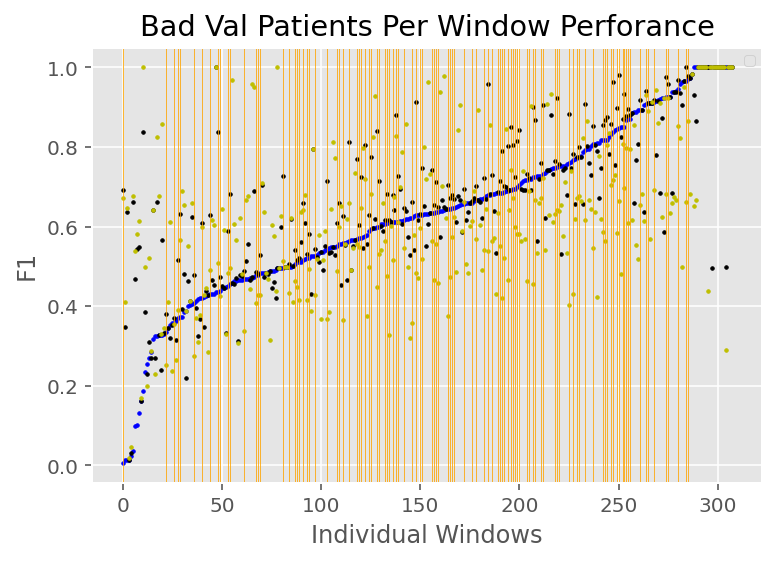

In [66]:
model_color ={ "eeg":"b","eog":"y","mm":"k","router_std":"r" }
c = 0
# for p in bad_performing_patients_perf: print(p)
# patient_sortargs = np.argsort(np.array([bad_performing_patients_perf_windows[p]["eeg"] for p in bad_performing_patients_perf]).flatten())
perf_w = np.zeros([0])
for p in bad_performing_patients_perf:
    a = np.array(bad_performing_patients_perf_windows[p]["eeg"]).flatten()
    perf_w = np.concatenate((perf_w, a.flatten()))
perf_w = np.array(perf_w).flatten()[1:]
patient_sortargs = np.argsort(perf_w)

perf_w = {}
for model in ["eeg","mm", "eog"]:
    perf_w[model] = np.zeros([0])
    for p in bad_performing_patients_perf:
        a = np.array(bad_performing_patients_perf_windows[p][model]).flatten()
        perf_w[model] = np.concatenate((perf_w[model], a.flatten()))
    perf_w[model] = np.array(perf_w[model]).flatten()[1:]
    # perf = np.array([bad_performing_patients_perf_windows[p][model] for p in bad_performing_patients_perf]).flatten()
    # plt.plot(np.arange(0,len(perf_w)), perf_w[patient_sortargs], color=model_color[model], label=model, linewidth=0.8)
    plt.scatter(np.arange(0,len(perf_w[model])), np.array(perf_w[model])[patient_sortargs], color=model_color[model], s=3)
    c += 0.05

colors = np.array(perf_w["eeg"][patient_sortargs]) < np.array(perf_w["mm"][patient_sortargs])
colors_eog = np.array(perf_w["eog"][patient_sortargs]) < np.array(perf_w["mm"][patient_sortargs])
colors = [colors[i] and colors_eog[i] for i in range(len(colors))]
colors = ["orange" if i else "lightblue" for i in colors]
count = 0
for i in range(len(perf_w[model])):
    if colors[i]=="orange":
        count+=1
        plt.axvline(i, 0, 1, color=colors[i], lw=0.4)
print(count)
plt.legend(fontsize=7)
plt.ylabel("F1")
plt.xlabel("Individual Windows")
plt.title("Bad Val Patients Per Window Perforance")
# plt.xticks(np.arange(0,len(perf)),bad_performing_patients, fontsize=3)
plt.show()

In [43]:
# perf_eeg = []
# perf_mm = []
# perf_eog = []
# for p in bad_performing_patients_perf:
perf_eeg = np.zeros([0])
perf_eog = np.zeros([0])
perf_mm = np.zeros([0])
for p in bad_performing_patients_perf:
    a = np.array(bad_performing_patients_perf_windows[p]["mm"]).flatten()
    b = np.array(bad_performing_patients_perf_windows[p]["eog"]).flatten()
    c = np.array(bad_performing_patients_perf_windows[p]["eeg"]).flatten()
    perf_mm = np.concatenate((perf_mm, a.flatten()))
    perf_eog = np.concatenate((perf_eog, b.flatten()))
    perf_eeg = np.concatenate((perf_eeg, c.flatten()))

perf_mm = np.array(perf_mm).flatten()[1:]
perf_eog = np.array(perf_eog).flatten()[1:]
perf_eeg = np.array(perf_eeg).flatten()[1:]
# perf_mm.append(perf_w)
# perf_eeg = np.concatenate(perf_eeg)
# perf_eog = np.concatenate(perf_eog)
# perf_mm = np.concatenate(perf_mm)

In [44]:
print(perf_eeg.shape)
print(perf_eog.shape)
print(perf_mm.shape)

(308,)
(308,)
(308,)


In [46]:
print((perf_mm>perf_eeg).sum())
print((perf_mm<perf_eeg).sum())

print((perf_mm>perf_eog).sum())
print((perf_mm<perf_eog).sum())

print((perf_eog>perf_eeg).sum())
print((perf_eog<perf_eeg).sum())

164
97
184
101
110
175


In [63]:
a = perf_mm<perf_eeg
b = perf_mm<perf_eog

print(a.sum())
print(b.sum())
print(np.array([a[i] and b[i] for i in range(len(a))]).sum())

97
101
39
